In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import torch
import numpy as np
from pprint import pprint
import pathlib as pl
import torchaudio
import whisper
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import Audio

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import (
    LlamaTokenizer,
    MistralConfig,
    MistralForCausalLM,
)
import torch
from torch.utils.data import DataLoader
import pathlib as pl

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, GenerationConfig

import torch
torch.backends.cuda.matmul.allow_tf32 = True

from src2.voixdb import util
from src2.voixdb.util import *
from src2.voixdb.dataset.music_caps import (
    MusicCapsDataset,
    load_csv,
)
from src2.voixdb.model import Model, TunableWhisperAudioEncoder, load_llm
from src2.voixdb.train import Trainer
from src2.voixdb.train_cfg import TrainerCfg


In [3]:
# !pip install datasets

In [4]:
# import whisper

# import torch
# from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
# from datasets import load_dataset


# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# model_id = "openai/whisper-large-v3"

# model = AutoModelForSpeechSeq2Seq.from_pretrained(
#     model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
# )
# model.to(device)

In [5]:
# from tqdm import tqdm
# with torch.no_grad():
#     with torch.amp.autocast(device_type="cuda",dtype=torch.float16):
#             [audio_encoder(util.load_audio_mels(entry["file"]).cuda()).cpu() for entry in tqdm(train_entries)]

In [6]:
import numpy as np
import random
import os
import torch

# Set seed for everything
seed = 1337
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [7]:
# Access the values of the arguments
tr_cfg = TrainerCfg(
    epoch=1,
    model_save_freq=1,
    device="cuda:0",
    model_out_dir="/root/out-model",
)

stage = "peft" # vs. "peft"
use_lora_projection = False # should the projection be a lora or a full rank matrix?
lr_default = 1e-4#0.5e-4
bs = 1

run_num = 13


class DummyEncoder(nn.Module):
    a=1
whisper_encoder = None#DummyEncoder() # set to None to auto-load it.

audio_encoder = TunableWhisperAudioEncoder(audio_encoder=whisper_encoder,use_lora=use_lora_projection) # it's not None, but I don't wanna load a heavy encoder
# audio_encoder.proj.load_state_dict(torch.load("../listening-with-llm-3/model_manual_save3.pth"),strict=False)
if stage == "peft":
    audio_encoder.proj.load_state_dict(torch.load("model_best_save6.pth"),strict=False)
    for param in audio_encoder.proj.parameters():
        param.requires_grad = False
        pass

audio_encoder.to(tr_cfg.device)

tokenizer,llm = load_llm()
model = Model(audio_encoder.to(torch.bfloat16), llm)

from peft import get_peft_model, prepare_model_for_int8_training,LoraConfig
if stage == "peft":

    # PEFT config
    lora_alpha = 32
    lora_dropout = 0.1
    lora_r = 16
    peft_config = LoraConfig(
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        r=lora_r,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=["k_proj", "q_proj", "v_proj", "up_proj", "down_proj", "gate_proj"]
    )
    model.llm = get_peft_model(model.llm, peft_config)

# print fraction of trainable params
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
fraction_trainable = trainable_params / total_params
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Fraction of parameters that are trainable: {fraction_trainable:.2%}")

entries = load_csv(load_raw=False)
train_size = int(len(entries) * 0.95)
train_entries = entries[:train_size]
eval_entries = entries[train_size:]

max_length = 400

embed_tokens = llm.model.embed_tokens
torch.save(embed_tokens.state_dict(),"embed.pt")
raw_embedding = nn.Embedding(embed_tokens.num_embeddings,embed_tokens.embedding_dim)
raw_embedding.load_state_dict(embed_tokens.state_dict())
raw_embedding.cpu()

eval_ds = MusicCapsDataset(eval_entries, tokenizer, util.prompt_template_fn,audio_encoder.audio_encoder,raw_embedding,max_length,key="eval-audio")
eval_dl = DataLoader(eval_ds, batch_size=bs, shuffle=True, num_workers=6)

train_ds = MusicCapsDataset(train_entries, tokenizer, util.prompt_template_fn,audio_encoder.audio_encoder,raw_embedding,max_length,key="train-audio")
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=12)



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


loading from pretrained


Error during conversion: ValueError('Queue is full! Please try again.')


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

loaded from pretrained
Total parameters: 4430823040
Trainable parameters: 37748736
Fraction of parameters that are trainable: 0.85%


In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# counts, bins = np.histogram(list(train_ds.raw_sizes))
# plt.stairs(counts, bins)

In [9]:
# row = train_ds[0]
# row['input_embeds_raw'][:,0]

In [10]:
# verify model weight
from collections import Counter
pbytype = Counter()
for name, p in (model.named_parameters()):
    if torch.isinf(p).any() or torch.isnan(p).any():
        print(name, p)
        raise ValueError("invalid weight")
    else:
        pbytype[p.dtype] += 1
print("OK", pbytype)

OK Counter({torch.bfloat16: 493, torch.float32: 384, torch.uint8: 224, torch.float16: 67})


In [11]:
# means = []
# stds = []
# norms = []
# for name, p in (model.audio_encoder.audio_encoder.named_parameters()):
#     if p.dim() == 2:
#         print(p.dtype)
#         print(p.max().item(), p.min().item())

#         means.append(p.mean().item())
#         stds.append(p.std().item())
#         norms.append(torch.linalg.norm(p.to(torch.float).cpu().detach()))
        
# plt.hist(means, bins=100, color='blue', alpha=0.7)

In [12]:
# norms = []
# means = []
# stds = []

# for name, p in (model.audio_encoder.proj.named_parameters()):
#     print(p.dtype)
#     print(p.max().item(), p.min().item())
#     means.append(p.mean().item())
#     stds.append(p.std().item())
#     norms.append(torch.linalg.norm(p.to(torch.float).cpu().detach()))

# plt.hist(means, bins=100, color='red', alpha=0.7)

In [13]:
@torch.no_grad
def sampler(input_ids):
    outputs = []
    for _ in range(50):
        inputs_embeds = model.llm.model.embed_tokens(input_ids)
        res = model.llm(inputs_embeds=inputs_embeds)
        sampled = torch.multinomial(res.logits[:,-1,:].softmax(dim=-1), 1)# .to(device)
        input_ids = torch.cat((input_ids, sampled), dim=-1)
    return input_ids
        

In [14]:
# tokenizer.decode(sampler(tokenizer("tell me a story", return_tensors="pt").input_ids.to(tr_cfg.device))[0])

In [15]:
import torch.optim as optim

adam_beta1 = 0.9
adama_beta2 = 0.999
adam_eps = 1e-8

# TODO: experiment with AdamW
optimizer = optim.Adam(
    [*model.parameters(),nn.Parameter(torch.tensor(1.0))],
    lr=lr_default,
    betas=(adam_beta1, adama_beta2),
    eps=adam_eps,
)
datagen = iter(train_dl)
device = tr_cfg.device
uds = []
losses = []

In [16]:
# from src2.voixdb.dataset.music_caps import MusicCapsDataset
# train_ds = MusicCapsDataset(train_entries, tokenizer, util.prompt_template_fn,audio_encoder.audio_encoder,raw_embedding,max_length,key="train-audio")
# train_dl = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1)
# datagen = iter(train_dl)

# from time import perf_counter
# start_time = perf_counter()
# for i in range(3):
#     b = next(datagen)

# time_per_iter = (perf_counter() - start_time) / 20

# time_per_iter
# # raise 1

In [17]:
{k:v.shape for k,v in train_ds[0].items() if torch.is_tensor(v)}

{'attention_mask': torch.Size([400]),
 'input_embeds_raw': torch.Size([400, 4096]),
 'input_ids_raw': torch.Size([400]),
 'audio_embeds_raw': torch.Size([2000, 1280]),
 'audio_tokens_start': torch.Size([]),
 'audio_tokens_end': torch.Size([]),
 'cap_tokens_start': torch.Size([]),
 'n_audio_embeds': torch.Size([])}

In [18]:
inputs_embeds = None
attention_mask = None
batch = None

def fwd(self, _batch):
    global inputs_embeds,attention_mask,batch
    batch = _batch
    attention_mask = batch["attention_mask"]
    inputs_embeds = batch["input_embeds_raw"].clone()
    audio_embeds_raw = batch["audio_embeds_raw"]

    audio_start = batch["audio_tokens_start"]
    audio_end = batch["audio_tokens_end"]

    n_audio_embeds = batch["n_audio_embeds"]

    # print({k:v.shape for k,v in batch.items()})

    # un-pad and project the audio embeddings separately
    audio_embeds = torch.stack([self.audio_encoder.proj(audio_embeds_raw[i,-n_audio_embeds[i]:]) for i in range(len(n_audio_embeds))])
    assert audio_embeds.shape[1] == 250,f"shape is {audio_embeds.shape}"

    N,*_ = audio_embeds.shape
    for i in range(N):
        # print(inputs_embeds.shape,audio_start[i],audio_end[i],audio_embeds.shape,audio_embeds_raw.shape)
        # print("curr_embeds",inputs_embeds[i,audio_start[i]:audio_end[i]])
        inputs_embeds[i,audio_start[i]:audio_end[i]] = audio_embeds[i]
    
    # print('cap_embeds', cap_embeds.mean(dim=1), cap_embeds.std(dim=1))
    mout = self.llm(
        inputs_embeds=inputs_embeds,
        # output_attentions=True,
        # output_hidden_states=True,
        attention_mask=attention_mask,
        # use_cache=False,
    )

    return mout, audio_embeds.shape[1]

In [19]:
local_batch = next(datagen)
batch = {
    k: v.to(device)
    for k, v in local_batch.items()
    if not k.startswith("_")
}
with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
    fwd(model,batch)
# raise 1

In [20]:
attention_mask

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.,

In [21]:
inputs_embeds[:,:,0]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -4.5776e-03,  6.2180e-04, -9.9182e-04, -1.0910e-03,
          1.7071e-04,  2.0142e-03,  3.7193e-04,  3.7384e-04, -7.5073e-03,
         -2.2697e-04, -6.3705e-04,  1.8997e-03,  1.4725e-03,  8.7738e-04,
          2.0264e-02,  6.2180e-04, -5.8365e-04, -1.0910e-03,  1.7071e-04,
          3.0975e-03,  3.0327e-04,  1.9531e-03, -6.3324e-04,  3.0327e-04,
          6.0272e-04, -1.0757e-03, -9.5752e-01, -2.7808e-01,  7.5342e-01,
          3.8379e-01,  1.0553e-01, -1.8091e-01,  6.2218e-03,  8.4912e-01,
         -6.5283e-01, -1.1006e+00, -1.4424e+00, -2.1216e-01,  1.3652e+00,
          1.2441e+00,  1.3721e-01, -6.

In [22]:
batch["audio_embeds_raw"][:,-1500:]

tensor([[[-0.5405, -0.2817,  0.0168,  ..., -0.8462, -0.2443, -0.1471],
         [ 0.2339, -0.5532,  0.4138,  ..., -0.5981, -0.3132,  0.0386],
         [ 0.2169, -0.0100, -0.0635,  ..., -0.1970,  0.0443, -0.2830],
         ...,
         [-0.2874, -0.4905,  0.0539,  ..., -0.2246,  0.2258, -0.5601],
         [-0.2269,  0.1908, -0.3420,  ...,  0.6001,  0.0133, -1.7236],
         [ 0.0264,  0.6362, -0.1864,  ...,  0.3386,  0.3479, -0.3062]]],
       device='cuda:0')

In [23]:
with torch.no_grad():
    with torch.amp.autocast(device_type="cuda",dtype=torch.float16):
        a=audio_encoder.audio_encoder(util.load_audio_mels(train_ds.entries[0]["file"]).cuda())
a

tensor([[[-0.4104,  0.0649,  0.5522,  ..., -0.1167, -0.3240, -0.6045],
         [ 0.1138, -0.9551, -0.2742,  ..., -0.4602, -0.3120, -0.3083],
         [ 0.0380, -0.3933, -0.4968,  ..., -0.1611, -0.2249, -0.3965],
         ...,
         [-0.4922, -0.2446, -0.2267,  ...,  0.0430, -0.1564, -1.2529],
         [-0.3904,  0.3357, -0.4678,  ...,  0.2822, -0.4429, -1.5586],
         [-0.1785,  0.7549, -0.4580,  ...,  0.3855,  0.0160, -0.4167]]],
       device='cuda:0', dtype=torch.float16)

In [24]:
# torch.sum(batch["attention_mask"][1] != 0)

In [25]:
# train_ds.raw_audio_embeds[0].shape

In [26]:
# targets[0]
# tokenizer.decode(targets[0,-84:])
# tokenizer.decode(torch.max(logits[0,-84:],dim=-1).indices)
# with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
#     b = model.audio_encoder.proj(batch["audio_embeds_raw"][0,-batch["n_audio_embeds"][0]:])
# b
# print(batch["n_audio_embeds"][0])
# print(torch.sum(batch["audio_embeds_raw"][0,:,0]!=0),batch["audio_embeds_raw"].shape)



In [27]:
def get_loss(local_batch):
    # Transfer to GPU
    batch = {
        k: v.to(device)
        for k, v in local_batch.items()
        if not k.startswith("_")
    }
    # compute
    with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
        mout, audio_seq = fwd(model, batch)

    targets = batch["input_ids_raw"][:]
    target_idxes = torch.arange(max_length,device=targets.device)[None]

    # remove the last output
    logits = mout.logits
    logits_start = batch["cap_tokens_start"].to(targets.device)

    # print()
    targets = torch.masked_fill(targets,target_idxes < logits_start[:,None],-100)[:,1:].long()
    
    # remove the prompt and audio seq from logits
    # calculation; additionally, remove the final item
    logits = logits[:, :-1, :].contiguous().to(targets.device)

    # logits = logits[:,-20:]
    # targets = targets[:,-20:]
    assert logits.shape[:2] == targets.shape[:2], f"shape is {logits.shape} and {targets.shape}"
    # print(logits.shape,targets.shape)

    loss = nn.functional.cross_entropy(
        logits.view(-1, logits.shape[-1]), targets.view(-1)
    )

    return loss


In [28]:
from tqdm import tqdm
# taken from https://gist.github.com/Tony-Y/03e47588bae2e2bfd69815d046d994ec
import pytorch_warmup as warmup

epochs = 50
steps_per_epoch = len(train_dl)
warmup_period = 1000
num_steps = steps_per_epoch * epochs - warmup_period
t0 = num_steps // 3 # first cosine anneal

lr_min = 3e-5
max_step = t0 * 3 + warmup_period

lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=t0, T_mult=1, eta_min=lr_min)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)

best_loss = 1e9

for _ in range(50):
    model.train()
    for i, local_batch in enumerate(train_dl):
        loss = get_loss(local_batch)

        # required to access grad on non leaf nodes
        for p in model.audio_encoder.proj.parameters():
            if p.requires_grad:
                p.retain_grad()
        
        # print("lossed")
    
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()


        with warmup_scheduler.dampening():
            if warmup_scheduler.last_step + 1 >= warmup_period:
                lr_scheduler.step()
        if warmup_scheduler.last_step + 1 >= max_step:
            break

        # print("backwarded")
        
        with torch.no_grad():
            ud = []
            for name, p in model.audio_encoder.proj.named_parameters():
                if not p.requires_grad or p.grad is None:
                    continue
                # if i % 10 == 0:
                #    print(name, p.grad.mean().item(), p.grad.std().item())
                ud.append(((lr_default*p.grad).std() / p.data.std()).log10().item())
            uds.append(ud)
            
        
        losses.append(loss.detach().cpu())
        del loss
        if i % 500 == 0:
            eval_losses = []
            with torch.no_grad():
                model.eval()
                for local_batch in tqdm(eval_dl):
                    eval_loss = get_loss(local_batch)
                    eval_losses.append(eval_loss.cpu())
            print(f"{i}: train={np.mean(losses):.4f} eval={np.mean(eval_losses):.4f}")
            if np.mean(eval_losses) < best_loss:
                best_loss = np.mean(eval_losses)
                if stage == "proj":
                    torch.save(
                        model.audio_encoder.proj.state_dict(),
                        f"model_best_save{run_num}.pth",
                    )
                elif stage == "peft":
                    # save peft params
                    filt_state_dict = {k:v for k,v in model.llm.state_dict().items() if "lora" in k}
                    torch.save(filt_state_dict, f"lora_best_save{run_num}.pth")
            del eval_losses


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


0: train=1.1825 eval=1.7797


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


500: train=1.6033 eval=1.7655


100%|██████████| 247/247 [00:47<00:00,  5.25it/s]


1000: train=1.6445 eval=1.7955


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


1500: train=1.6698 eval=1.7516


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


2000: train=1.6750 eval=1.7573


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


2500: train=1.6636 eval=1.6849


100%|██████████| 247/247 [00:47<00:00,  5.25it/s]


3000: train=1.6565 eval=1.6722


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


3500: train=1.6516 eval=1.6709


100%|██████████| 247/247 [00:47<00:00,  5.25it/s]


4000: train=1.6481 eval=1.6419


100%|██████████| 247/247 [00:47<00:00,  5.25it/s]


4500: train=1.6456 eval=1.6576


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


0: train=1.6424 eval=1.6289


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


500: train=1.6127 eval=1.6540


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


1000: train=1.5898 eval=1.6533


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


1500: train=1.5681 eval=1.6332


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


2000: train=1.5503 eval=1.6356


100%|██████████| 247/247 [00:47<00:00,  5.25it/s]


2500: train=1.5388 eval=1.6524


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


3000: train=1.5283 eval=1.6237


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


3500: train=1.5188 eval=1.6244


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


4000: train=1.5103 eval=1.6198


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


4500: train=1.5030 eval=1.6352


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


0: train=1.5008 eval=1.6257


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


500: train=1.4742 eval=1.7352


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


1000: train=1.4513 eval=1.7289


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


1500: train=1.4313 eval=1.6877


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


2000: train=1.4145 eval=1.7318


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


2500: train=1.4002 eval=1.7430


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


3000: train=1.3879 eval=1.7036


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


3500: train=1.3767 eval=1.6799


100%|██████████| 247/247 [00:47<00:00,  5.25it/s]


4000: train=1.3670 eval=1.6873


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


4500: train=1.3586 eval=1.6835


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


0: train=1.3558 eval=1.6786


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


500: train=1.3338 eval=1.8190


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


1000: train=1.3146 eval=1.8014


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


1500: train=1.2973 eval=1.8395


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


2000: train=1.2820 eval=1.8209


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


2500: train=1.2682 eval=1.8122


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


3000: train=1.2557 eval=1.8238


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


3500: train=1.2447 eval=1.8719


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


4000: train=1.2354 eval=1.8224


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


4500: train=1.2270 eval=1.7899


100%|██████████| 247/247 [00:47<00:00,  5.21it/s]


0: train=1.2242 eval=1.7844


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


500: train=1.2061 eval=1.9671


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


1000: train=1.1901 eval=1.9798


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


1500: train=1.1759 eval=1.9745


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


2000: train=1.1627 eval=1.9174


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


2500: train=1.1509 eval=1.9274


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


3000: train=1.1400 eval=1.9093


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


3500: train=1.1301 eval=1.9254


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


4000: train=1.1208 eval=1.9209


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


4500: train=1.1122 eval=1.9188


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


0: train=1.1094 eval=1.9474


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


500: train=1.0949 eval=2.0588


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


1000: train=1.0816 eval=2.1418


100%|██████████| 247/247 [00:47<00:00,  5.21it/s]


1500: train=1.0695 eval=2.0121


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


2000: train=1.0580 eval=2.0810


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


2500: train=1.0478 eval=2.0770


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


3000: train=1.0381 eval=2.0375


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


3500: train=1.0291 eval=2.0462


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


4000: train=1.0208 eval=2.0432


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


4500: train=1.0131 eval=2.0200


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


0: train=1.0104 eval=2.0079


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


500: train=0.9981 eval=2.1940


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


1000: train=0.9868 eval=2.2146


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


1500: train=0.9762 eval=2.2107


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


2000: train=0.9666 eval=2.1370


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


2500: train=0.9575 eval=2.1349


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


3000: train=0.9490 eval=2.1841


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


3500: train=0.9408 eval=2.1442


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


4000: train=0.9333 eval=2.1439


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


4500: train=0.9259 eval=2.1500


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


0: train=0.9234 eval=2.1280


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


500: train=0.9131 eval=2.2933


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


1000: train=0.9034 eval=2.2897


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


1500: train=0.8942 eval=2.2950


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


2000: train=0.8856 eval=2.2395


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


2500: train=0.8776 eval=2.2722


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


3000: train=0.8700 eval=2.2384


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


3500: train=0.8626 eval=2.2922


100%|██████████| 247/247 [00:47<00:00,  5.21it/s]


4000: train=0.8558 eval=2.2382


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


4500: train=0.8489 eval=2.2517


100%|██████████| 247/247 [00:47<00:00,  5.21it/s]


0: train=0.8465 eval=2.3092


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


500: train=0.8378 eval=2.4255


100%|██████████| 247/247 [00:47<00:00,  5.21it/s]


1000: train=0.8293 eval=2.3895


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


1500: train=0.8215 eval=2.2986


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


2000: train=0.8140 eval=2.3706


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


2500: train=0.8069 eval=2.3396


100%|██████████| 247/247 [00:47<00:00,  5.21it/s]


3000: train=0.8000 eval=2.4008


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


3500: train=0.7934 eval=2.3547


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


4000: train=0.7869 eval=2.3443


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


4500: train=0.7808 eval=2.3722


100%|██████████| 247/247 [00:47<00:00,  5.20it/s]


0: train=0.7786 eval=2.3584


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


500: train=0.7711 eval=2.4874


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


1000: train=0.7639 eval=2.4811


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


1500: train=0.7569 eval=2.4553


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


2000: train=0.7502 eval=2.4451


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


2500: train=0.7438 eval=2.4781


100%|██████████| 247/247 [00:47<00:00,  5.21it/s]


3000: train=0.7377 eval=2.4218


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


3500: train=0.7316 eval=2.4758


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


4000: train=0.7258 eval=2.4399


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


4500: train=0.7202 eval=2.4171


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


0: train=0.7183 eval=2.3809


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


500: train=0.7118 eval=2.6432


100%|██████████| 247/247 [00:47<00:00,  5.21it/s]


1000: train=0.7054 eval=2.5020


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


1500: train=0.6993 eval=2.6095


100%|██████████| 247/247 [00:47<00:00,  5.21it/s]


2000: train=0.6935 eval=2.5531


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


2500: train=0.6877 eval=2.5112


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


3000: train=0.6823 eval=2.5214


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


3500: train=0.6769 eval=2.5484


100%|██████████| 247/247 [00:47<00:00,  5.21it/s]


4000: train=0.6718 eval=2.4670


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


4500: train=0.6666 eval=2.4911


100%|██████████| 247/247 [00:47<00:00,  5.21it/s]


0: train=0.6649 eval=2.5383


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


500: train=0.6592 eval=2.6691


100%|██████████| 247/247 [00:47<00:00,  5.20it/s]


1000: train=0.6537 eval=2.6377


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


1500: train=0.6484 eval=2.5989


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


2000: train=0.6432 eval=2.5954


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


2500: train=0.6382 eval=2.6096


100%|██████████| 247/247 [00:47<00:00,  5.21it/s]


3000: train=0.6333 eval=2.6362


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


3500: train=0.6285 eval=2.5774


100%|██████████| 247/247 [00:47<00:00,  5.21it/s]


4000: train=0.6238 eval=2.5957


100%|██████████| 247/247 [00:47<00:00,  5.23it/s]


4500: train=0.6192 eval=2.5667


100%|██████████| 247/247 [00:47<00:00,  5.20it/s]


0: train=0.6176 eval=2.5969


100%|██████████| 247/247 [00:47<00:00,  5.19it/s]


500: train=0.6127 eval=2.6527


100%|██████████| 247/247 [00:47<00:00,  5.21it/s]


1000: train=0.6079 eval=2.6902


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


1500: train=0.6031 eval=2.7337


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


2000: train=0.5986 eval=2.6854


100%|██████████| 247/247 [00:47<00:00,  5.21it/s]


2500: train=0.5941 eval=2.6326


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


3000: train=0.5897 eval=2.7563


100%|██████████| 247/247 [00:47<00:00,  5.20it/s]


3500: train=0.5854 eval=2.6438


100%|██████████| 247/247 [00:47<00:00,  5.20it/s]


4000: train=0.5812 eval=2.7424


100%|██████████| 247/247 [00:47<00:00,  5.20it/s]


4500: train=0.5771 eval=2.7523


100%|██████████| 247/247 [00:47<00:00,  5.19it/s]


0: train=0.5756 eval=2.6602


100%|██████████| 247/247 [00:47<00:00,  5.20it/s]


500: train=0.5713 eval=2.7739


100%|██████████| 247/247 [00:47<00:00,  5.21it/s]


1000: train=0.5670 eval=2.7831


100%|██████████| 247/247 [00:47<00:00,  5.20it/s]


1500: train=0.5629 eval=2.7570


100%|██████████| 247/247 [00:47<00:00,  5.20it/s]


2000: train=0.5588 eval=2.7411


100%|██████████| 247/247 [00:47<00:00,  5.19it/s]


2500: train=0.5549 eval=2.7483


100%|██████████| 247/247 [00:47<00:00,  5.21it/s]


3000: train=0.5510 eval=2.7521


100%|██████████| 247/247 [00:47<00:00,  5.20it/s]


3500: train=0.5472 eval=2.6990


100%|██████████| 247/247 [00:47<00:00,  5.18it/s]


4000: train=0.5434 eval=2.7389


100%|██████████| 247/247 [00:47<00:00,  5.21it/s]


4500: train=0.5397 eval=2.7571


100%|██████████| 247/247 [00:47<00:00,  5.17it/s]


0: train=0.5384 eval=2.7553


100%|██████████| 247/247 [00:47<00:00,  5.19it/s]


500: train=0.5346 eval=2.7994


100%|██████████| 247/247 [00:47<00:00,  5.21it/s]


1000: train=0.5308 eval=2.8201


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


1500: train=0.5272 eval=2.8524


100%|██████████| 247/247 [00:47<00:00,  5.20it/s]


2000: train=0.5236 eval=2.8018


100%|██████████| 247/247 [00:47<00:00,  5.19it/s]


2500: train=0.5201 eval=2.7283


100%|██████████| 247/247 [00:47<00:00,  5.20it/s]


3000: train=0.5166 eval=2.7587


100%|██████████| 247/247 [00:47<00:00,  5.19it/s]


3500: train=0.5132 eval=2.7629


100%|██████████| 247/247 [00:47<00:00,  5.20it/s]


4000: train=0.5100 eval=2.7428


100%|██████████| 247/247 [00:47<00:00,  5.18it/s]


4500: train=0.5067 eval=2.8410


100%|██████████| 247/247 [00:47<00:00,  5.16it/s]


0: train=0.5056 eval=2.8088


100%|██████████| 247/247 [00:47<00:00,  5.19it/s]


500: train=0.5022 eval=2.8823


100%|██████████| 247/247 [00:47<00:00,  5.18it/s]


1000: train=0.4989 eval=2.9395


100%|██████████| 247/247 [00:47<00:00,  5.19it/s]


1500: train=0.4956 eval=2.9219


100%|██████████| 247/247 [00:47<00:00,  5.19it/s]


2000: train=0.4924 eval=2.8388


100%|██████████| 247/247 [00:47<00:00,  5.18it/s]


2500: train=0.4893 eval=2.9298


100%|██████████| 247/247 [00:47<00:00,  5.18it/s]


3000: train=0.4862 eval=2.9141


100%|██████████| 247/247 [00:47<00:00,  5.18it/s]


3500: train=0.4831 eval=2.8809


100%|██████████| 247/247 [00:47<00:00,  5.19it/s]


4000: train=0.4801 eval=2.9031


100%|██████████| 247/247 [00:47<00:00,  5.19it/s]


4500: train=0.4772 eval=2.8781


100%|██████████| 247/247 [00:47<00:00,  5.19it/s]


0: train=0.4762 eval=2.8938


100%|██████████| 247/247 [00:47<00:00,  5.18it/s]


500: train=0.4732 eval=2.9807


100%|██████████| 247/247 [00:47<00:00,  5.20it/s]


1000: train=0.4702 eval=2.9487


100%|██████████| 247/247 [00:47<00:00,  5.19it/s]


1500: train=0.4673 eval=2.9186


KeyboardInterrupt: 

In [ ]:
# if stage == "peft":
#     model.llm.load_state_dict(torch.load(f"lora_best_save{run_num}.pth"),strict=False)
# elif stage  == "proj":
#   model.audio_encoder.proj.load_state_dict(torch.load(f"model_best_save{run_num}.pth"))

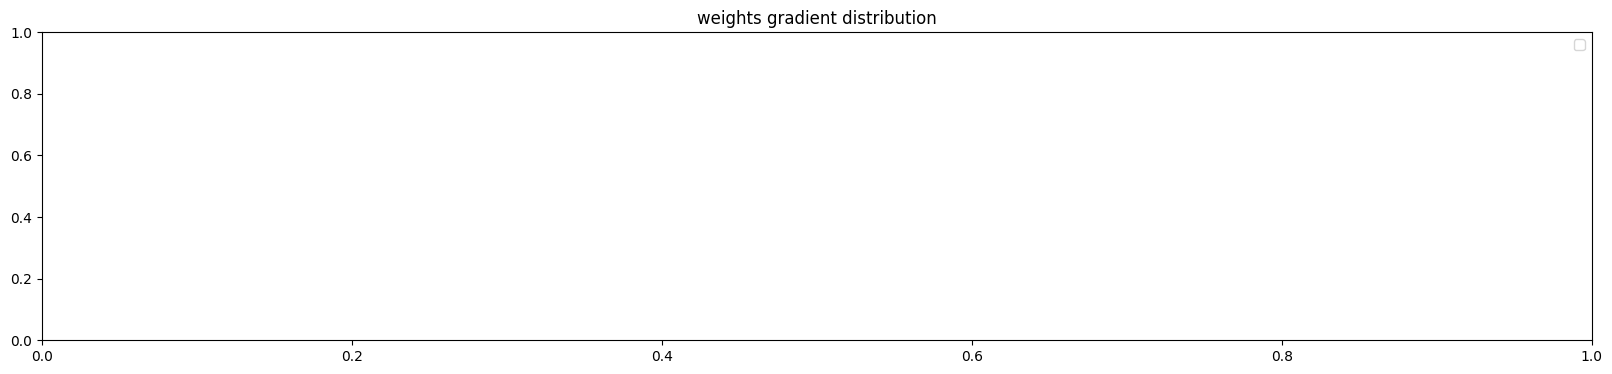

In [29]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
parameters = []
for i, l in enumerate([model.audio_encoder.proj]):
    #print('layer', l.__class__)
    for name, p in l.named_parameters():
        t = p.grad
        
        if t is None:
            continue

        print('layer %s | weight %10s | mean %+f | std %e | grad:data ratio %e' % (
            name, tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))

        hy, hx = np.histogram(t.to(torch.float32).cpu().detach().numpy())
        plt.plot(hx[:-1], hy)
        legends.append(f'{name} {tuple(p.shape)}')
            
plt.legend(legends)
plt.title('weights gradient distribution');

Text(0.5, 1.0, 'weight update relative to weight data, log scale')

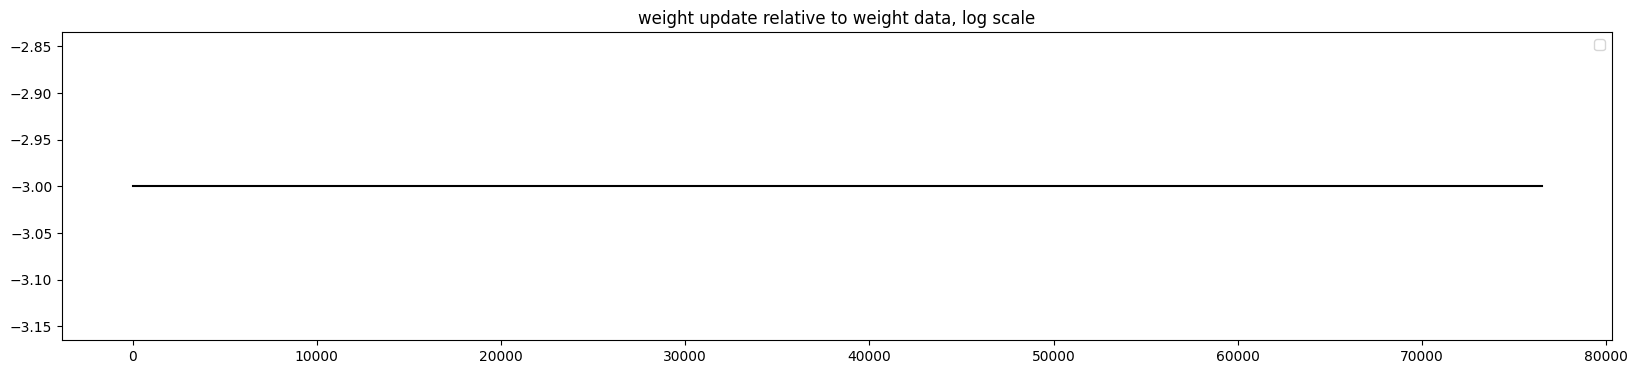

In [30]:
plt.figure(figsize=(20, 4))
legends = []
i = 0
for name, p in (model.audio_encoder.proj.named_parameters()):
    if p.grad is None:
        continue
    
    plt.plot([uds[epoch][i] for epoch in range(len(uds))])
    legends.append(name)

    i += 1
            
plt.plot([0, len(uds)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title("weight update relative to weight data, log scale")


In [31]:
l = torch.tensor(losses)

In [32]:
l[-50:].mean()

tensor(0.0397)

In [33]:
size_to_clip = l.size(0) - (l.size(0) % 100)
ml = l[:size_to_clip].reshape(-1, 100).mean(axis=1)


(0.0, 2.0)

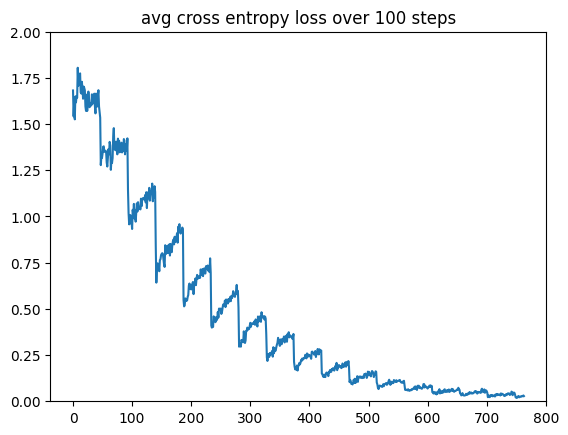

In [34]:
plt.plot(range((ml.shape[0])), ml.numpy())
plt.title("avg cross entropy loss over 100 steps")
plt.ylim(0, 2)

In [39]:
if stage == "proj":
    out = f"model_manual_save{run_num}.pth"

    torch.save(
        model.audio_encoder.proj.state_dict(),
        out,
    )
elif stage == "peft":
    out = f"lora_manual_save{run_num}.pth"

    filtered_state_dict = {k:v for k,v in model.llm.state_dict().items() if "lora" in k}
    torch.save(filtered_state_dict, out)


In [35]:
from src2.voixdb.dataset.music_caps import MusicCapsDataset
eval_ds = MusicCapsDataset(eval_entries, tokenizer, util.prompt_template_fn,audio_encoder.audio_encoder,raw_embedding,max_length,key="eval-audio")
eval_dl = DataLoader(eval_ds, batch_size=1, shuffle=True, num_workers=1)
datagen=iter(eval_dl)

In [64]:
local_batch = next(datagen)
audio_file = local_batch["_id"][0][0]

print(tokenizer.decode(local_batch["input_ids_raw"][0]))
Audio(audio_file)

<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><s> <|im_start|>  system
    You are a helpful AI who follows instruction carefully<|im_end|> <|im_start|>  user
    Describe the sound of the given file<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><u

In [56]:
model.llm.load_state_dict(torch.load(f"lora_manual_save{run_num}.pth"),strict=False)


_IncompatibleKeys(missing_keys=['base_model.model.model.embed_tokens.weight', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.o_proj.weight', 'base_model.model.model.layers.0.mlp.gate_proj.base_layer.weight', 'base_model.model.model.layers.0.mlp.up_proj.base_layer.weight', 'base_model.model.model.layers.0.mlp.down_proj.base_layer.weight', 'base_model.model.model.layers.0.input_layernorm.weight', 'base_model.model.model.layers.0.post_attention_layernorm.weight', 'base_model.model.model.layers.1.self_attn.q_proj.base_layer.weight', 'base_model.model.model.layers.1.self_attn.k_proj.base_layer.weight', 'base_model.model.model.layers.1.self_attn.v_proj.base_layer.weight', 'base_model.model.model.layers.1.self_attn.o_proj.weight', 'base_model.model.model.layers.1.mlp.gate_proj.base_layer.we

In [ ]:
modified_ckpts = [{
    "filename": "model_best_save6.pth", # my proj layer from this morning - I think slightly better than blog post
    "use_lora": True
},{
    "filename": "../listening-with-llm-3/model_manual_save3.pth", # the OG checkpoint from the blog post
    "use_lora": False
}]

filename = "model_best_save6.pth" or "../listening-with-llm-3/model_manual_save3.pth"
model.audio_encoder.proj.load_state_dict(torch.load(filename),strict=False)
model.audio_encoder.proj.use_lora = torch.tensor(False)



In [65]:
from src2.voixdb.util import sample_with_audio
for i in range(5):
    print(tokenizer.decode(sample_with_audio(model, llm, tokenizer, prompt_template_fn(), audio_file, iteration=100)[0]))

<s> <|im_start|>  system
    You are a helpful AI who follows instruction carefully<|im_end|> <|im_start|>  user
    Describe the sound of the given file 
    <|im_end|> <|im_start|> assistant
     The low quality recording features a theremin solo melody. It sounds spacey and weird, as the recording is noisy. There are some instrument crackling sounds. A ribbon sound effect runs through the recording. It sounds like something you would hear in a sci-fi movie. There are some bells melody themes in the background. This recording is spacey and weird. It seems like a demo for a sci-fi video game. This song may be played in
<s> <|im_start|>  system
    You are a helpful AI who follows instruction carefully<|im_end|> <|im_start|>  user
    Describe the sound of the given file 
    <|im_end|> <|im_start|> assistant
     The low quality recording features a theremin solo melody. It sounds spacey and weird, as the recording is noisy. There are some tinny metallic impacts along with some hummin

In [38]:
import torch
import whisper

def prompt_template_fn(prompt="Describe the sound of the given file"):
    system_message = "You are a helpful AI who follows instruction carefully"

    prompt_prefix = f"""<|im_start|>system
    {system_message}<|im_end|>
    <|im_start|>user
    {prompt}"""

    return prompt_prefix


def end_template():
    return """
    <|im_end|>
    <|im_start|>assistant
    """


def load_audio_mels(file):
    audio = whisper.load_audio(file)
    audio = whisper.pad_or_trim(audio)
    audio_mels = whisper.log_mel_spectrogram(audio, n_mels=128)
    audio_mels = audio_mels.unsqueeze(0)
    return audio_mels


def text_2_ids_and_attention_mask(tokenizer, input_txt, truncate=False):
    txt = input_txt
    res = tokenizer(txt, return_tensors="pt")

    if truncate:
        return res.input_ids[:, 1:], res.attention_mask[:, 1:]

    return res.input_ids, res.attention_mask

@torch.no_grad()
def sample_with_audio(model, tokenizer, prompt, audio_file, device="cuda:0", iteration=50):
    audio_mels = load_audio_mels(audio_file).to(device).half()
    end_prompt_ids, end_prompt_attention_mask = text_2_ids_and_attention_mask(
        tokenizer,
        end_template(),
        truncate=True,
    )
    prompt_ids, prompt_attention_mask = text_2_ids_and_attention_mask(
        tokenizer,
        prompt,
    )

    prompt_ids = prompt_ids.to(device)
    prompt_attention_mask = prompt_attention_mask.to(device)
    end_prompt_attention_mask = end_prompt_attention_mask.to(device)
    end_prompt_ids = end_prompt_ids.to(device)
    sampled_ids = None

    prompt_embeds = None
    end_prompt_embeds = None
    audio_embeds = None

    with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
        if audio_embeds is None:
            audio_embeds = model.audio_encoder(audio_mels)
        bs, audio_seq = audio_embeds.shape[:2]
        
        mask_concat_args = [
            prompt_attention_mask,
            torch.ones(bs, audio_seq).to(audio_embeds.device),
            end_prompt_attention_mask,
        ]

        for _ in range(iteration):
            if sampled_ids is not None:
                mask_concat_args.append(torch.ones(bs, sampled_ids.shape[1]).to(audio_embeds.device))
                
            attention_mask = torch.concat(
                tuple(mask_concat_args),
                dim=1,
            )

            if prompt_embeds is None:
                prompt_embeds = model.llm.model.embed_tokens(prompt_ids)
            if end_prompt_embeds is None:
                end_prompt_embeds = model.llm.model.embed_tokens(end_prompt_ids)
                
            sampled_ids_embeds = None
            if sampled_ids is not None:
                sampled_ids_embeds = model.llm.model.embed_tokens(sampled_ids)
                
            embeds_concat_args = [
                prompt_embeds,
                audio_embeds.to(prompt_embeds.dtype),
                end_prompt_embeds,
            ]
            if sampled_ids_embeds is not None:
                embeds_concat_args.append(sampled_ids_embeds)
                
            inputs_embeds = torch.concat(
                tuple(embeds_concat_args),
                dim=1,
            )
    
            mout = model.llm(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
            )
    
            logits = mout.logits
            sampled = torch.multinomial(logits[:, -1, :].softmax(dim=-1), 1)
            
            if sampled_ids is None:
                sampled_ids = sampled
            else:
                sampled_ids = torch.cat((sampled_ids, sampled), dim=-1).to(device)

    # print(prompt_ids.shape)
    # print(end_prompt_ids.shape)
    # print(sampled_ids.shape)
    
    return torch.concat((
        prompt_ids, 
        end_prompt_ids,
        sampled_ids,
    ),dim=-1)
